<a href="https://colab.research.google.com/github/NatashaKamami/Advanced_ML/blob/main/Retail_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Data Explotation libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #Visualization
import seaborn as sns #Advanced Visualization
%matplotlib inline

# Data Encoding
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Clustering
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer


In [2]:
df = pd.read_csv('/content/Online Retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.isnull().sum()/len(df)*100

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


In [5]:
df.duplicated().sum()

5268

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.dropna(subset=['Description'], inplace=True)
df.dropna(subset=['CustomerID'], inplace=True)

In [8]:
df.drop(columns=['InvoiceNo'], inplace=True)

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d/%m/%Y %H:%M')

In [10]:
# Preprocess the InvoiceDate to extract useful features (e.g., days since a reference date)
df['DaysSinceInvoice'] = (df['InvoiceDate'] - df['InvoiceDate'].min()).dt.days

# Drop 'InvoiceDate' column as it's already encoded in 'DaysSinceInvoice'
df.drop(columns=['InvoiceDate'], inplace=True)

In [11]:
# Preprocessing pipeline for numerical and categorical features
# Select numerical columns for scaling
numerical_features = ['Quantity', 'UnitPrice', 'CustomerID', 'DaysSinceInvoice']
categorical_features = ['StockCode', 'Description', 'Country']

# Preprocessing  for numerical and categorical features
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),  # StandardScaler for numerical features
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

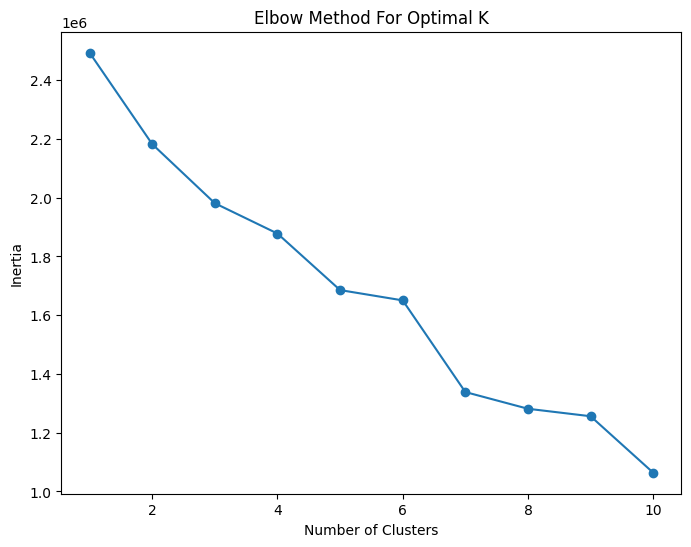

In [12]:
# Elbow method to find the optimal number of clusters
inertia = []
for k in range(1, 11):  # Try K values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(preprocessor.fit_transform(df))  # Fit on the preprocessed data
    inertia.append(kmeans.inertia_)

# Plot Elbow Graph to find the optimal k
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [14]:
# Define the KMeans model
kmeans = KMeans(n_clusters=7, random_state=42)  # Adjust the number of clusters as needed

# Create a pipeline that first transforms the data and then applies KMeans
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('kmeans', kmeans)
])

# Fit the model
model.fit(df)

# Get the cluster labels (which cluster each sample belongs to)
df['Cluster'] = model['kmeans'].labels_

# Show the first few rows of the DataFrame with clusters
print(df.head())


  StockCode                          Description  Quantity  UnitPrice  \
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6       2.55   
1     71053                  WHITE METAL LANTERN         6       3.39   
2    84406B       CREAM CUPID HEARTS COAT HANGER         8       2.75   
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6       3.39   
4    84029E       RED WOOLLY HOTTIE WHITE HEART.         6       3.39   

   CustomerID         Country  DaysSinceInvoice  Cluster  
0     17850.0  United Kingdom                 0        2  
1     17850.0  United Kingdom                 0        2  
2     17850.0  United Kingdom                 0        2  
3     17850.0  United Kingdom                 0        2  
4     17850.0  United Kingdom                 0        2  


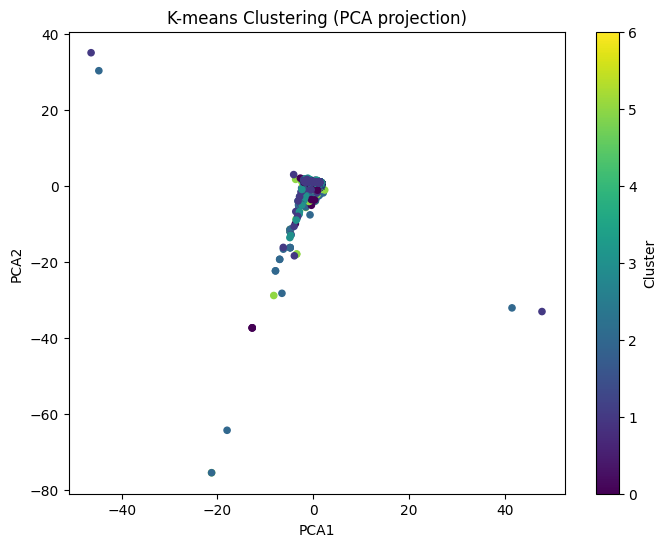

In [15]:
from sklearn.decomposition import PCA
# Optional: Visualize the clusters using PCA (Dimensionality Reduction)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for easy visualization
df_pca = pca.fit_transform(preprocessor.fit_transform(df))

# Create a DataFrame with PCA components and the assigned clusters
df_pca = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df['Cluster']

# Plot the clusters in a 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PCA1'], df_pca['PCA2'], c=df_pca['Cluster'], cmap='viridis', s=20)
plt.title('K-means Clustering (PCA projection)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.show()
